# Top Trendings do Twitter
**Objetivos:** Desenvolver uma aplicação para monitorar o top trending e seu devido volume na rede social com o passar do tempo.

## Funcionalidades
**Requisitos funcionais obrigatorios**:
- [X] Utilizar a api do twitter para consumir o top trending e seu devido volume.
- [X] Armazenar o histórico das trendings em um banco de dados noSQL.
- [X] Utilizar alguma biblioteca gráfica para exibir os dados.

**Requisito funcional opcional**:
- [X] Utilizar IA para análise de sentimento dos tweets referentes aos top trendings

### Instação das Bibliotecas
Para instalar as bibliotecas, será usado um arquivo de texto com todas as dependências necessarias para este projeto funcionar.

In [1]:
! python -m pip install -r requirements.txt

### Imports

In [2]:
import json
import pprint

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from modules import mongoDb
from modules import fileToDic as fd
from modules import apiKeys as api
from modules import mongoEnv
from modules import TwitterClient as tc

## Funcionalidade 1: Consome o top trending e seu devido volume.

1. Abrir o arquivo `WOEID.txt` para poder ler os paises e seu identificadores.
2. Usando a função `dictionary` que esta no arquivo `fileToDic`, o arquivo com os paises e seus respectivos valores serão convertidos em dicionario.
3. Usando o dicionario `key` que está no arquivo `apiKeys`, o valor do `BEARER_TOKEN` no arquivo `.env` será atribuido a varivel `bearer_token`. O Bearer Token será usado na autenticação da url que retorna os *trends* de um determinado pais.
4. Para buscar o trending de um determinado pais iremos usar a url: https://api.twitter.com/1.1/trends/place.json
5. Entretanto, devemos passar o parametro que no caso é o id de um pais.

Fonte: https://developer.twitter.com/en/docs/twitter-api/v1/trends/trends-for-location/api-reference/get-trends-place

In [12]:
countries = {}
file = open("input/WOEID.txt")
countries = fd.dictionary(file, countries)

bearer_token = api.key['bearer_token']

search_url = "https://api.twitter.com/1.1/trends/place.json"

query_params = {'id': countries['BRAZIL'], 'exclude': 'hashtags'}

Está função usa o *bearer token* para poder realizar a autenticação, por mais que não irá logar no **twitter** o *bearer token* "representa uma autorização do Server emitida para o client. Por sua vez, o client deve possuir mecanismos próprios para identificar e validar o Token".

Fonte: [Bruno Brito](https://www.brunobrito.net.br/jwt-cookies-oauth-bearer/).

In [13]:
def bearer_oauth(r):
  '''
  Autenticação usando o bearer token
  '''
  r.headers["Authorization"] = f"Bearer {bearer_token}"
  r.headers["User-Agent"] = "v2RecentSearchPython"

  return r

Usando a url e o parametros necessario, a função abaixo retorna um *response* no formato **json**. Veja onde a função `bearer_oauth` será usada.

Fonte: https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Recent-Search/recent_search.py

In [14]:
def connect_to_endpoint(url, params):
  '''
  Se conecta a url dada com o parametros dado.
  Consultar a documentação para saber o parametros nessario na pesquisa
  '''
  response = requests.get(url, auth=bearer_oauth, params=params)
  print(response.status_code)
  if response.status_code != 200:
    raise Exception(response.status_code, response.text)
        
  return response.json()

## Funcionalidade 2: Persistir os dados

1. criar conexão com o banco, neste projeto usando o MongoDb
2. Criar um banco chamado `tweets_db`
3. Criar uma coleção chamada `top_trends`
4. Inserir a *response* nesta coleção

Fonte: https://pymongo.readthedocs.io/en/stable/tutorial.html

### Variaveis de Ambiente

In [15]:
username = mongoEnv.key_mongo['mongo_username']
pwd = mongoEnv.key_mongo['mongo_password']

### Conexão com banco de dados

In [16]:
mongo_client = mongoDb.connect_to_mongo(username, pwd, '27017')

### Criação do Banco de Dados e a Coleção

In [17]:
database = mongoDb.create_db(mongo_client, 'tweets_db')
collection = database['top_trends']

### Conectando ao Endpoint da Twitter API

In [18]:
top_trends = connect_to_endpoint(search_url, query_params)

200


### Persistindo os dados encontrado no Json
Aqui eu decidi fazer um for para inserir um de cada vez, porém eu observei que só foi criado um unico documento, sendo que os top trendings é uma lista com os 50 top trendings da data atual.

In [19]:
for trend in top_trends:
    trend_id = collection.insert_one(trend).inserted_id

### Procurando e Printando o primeiro documento

In [20]:
pprint.pprint(collection.find_one())

{'_id': ObjectId('6147193c5b64b01e186febf6'),
 'as_of': '2021-09-19T11:04:28Z',
 'created_at': '2021-09-15T02:00:22Z',
 'locations': [{'name': 'Brazil', 'woeid': 23424768}],
 'trends': [{'name': '#Calamidade',
             'promoted_content': None,
             'query': '%23Calamidade',
             'tweet_volume': 286336,
             'url': 'http://twitter.com/search?q=%23Calamidade'},
            {'name': 'Otis',
             'promoted_content': None,
             'query': 'Otis',
             'tweet_volume': 59009,
             'url': 'http://twitter.com/search?q=Otis'},
            {'name': 'Paulo Freire',
             'promoted_content': None,
             'query': '%22Paulo+Freire%22',
             'tweet_volume': 43627,
             'url': 'http://twitter.com/search?q=%22Paulo+Freire%22'},
            {'name': 'juliette no altas horas',
             'promoted_content': None,
             'query': '%22juliette+no+altas+horas%22',
             'tweet_volume': 84069,
             

             'url': 'http://twitter.com/search?q=Khai'}]}


### Printando o nome da coleção criada no banco de dados

In [21]:
database.list_collection_names()

['top_trends']

## Funcionalidade 3: Visualizando os Dados

1. Extrair as trends de um determinado pais. 
2. Tratar dos campos NaN.
2. Usar a biblioteca pandas para criar um Dataframe dos *trends*
3. Usar a biblioteca pandas para visualizar os dados em um gráfico
4. Usar a biblioteca matplot para visualizar os dados em um gráfico 

Fontes: [Analise Exploratoria - Projeto DIO](https://github.com/LeiteSS/analise_exploratoria); [Plot With Pandas: Python Data Visualization for Beginners](https://realpython.com/pandas-plot-python/); [Return Json List And Python Requests Library](https://stackoverflow.com/questions/51458509/return-json-list-and-python-requests-library); [How to Increase Image Size of Pandas Dataframe plot in Jupyter Notebook](https://stackoverflow.com/questions/51174691/how-to-increase-image-size-of-pandas-dataframe-plot-in-jupyter-notebook) 

### Extrai as Trends

In [22]:
trends = []
for item in top_trends:
    trends = item['trends']

### Dataframe com as Trends

In [23]:
df = pd.DataFrame(trends)

#### Comandos Importantes
Deixei anexados aqui alguns comando que foram usados depois de ter convertido a lista em Dataframe.
```py
df.head() # retorna as primeiras 5 linhas (por padrão) de um dataframe

df.shape # retorna a quantidade de linha e a quantidade de colunas de um dataframe

df.dtypes # retorna o tipo de cada coluna
```

### Mudando os Nomes dos Campos

In [24]:
df_trends = df.rename(
    columns={
        'name': 'Nome', 
        'url': 'URI', 
        'promoted_content': 'Patrocinado', 
        'query': 'Hashtag', 
        'tweet_volume': 'Volume'
    }
)

### Preenche os valores *Not A Number* com Zeros

In [25]:
df_trends["Volume"].fillna(0, inplace=True)

### Agrupando os nomes com o volume de tweets
Este projeto irá apresentar o volume de tweets usando uma determinado nome que uma determinada hashtag tem.

In [26]:
# Qual o volume de tweet usando o nome como indicador
df_trends.groupby("Nome")["Volume"].mean()

Nome
2 MESES DE FRANÇA          0.0
Barney                     0.0
Boquetinho                 0.0
Brock                      0.0
Calleri                    0.0
Chelsea               290064.0
Cruzeiro               32473.0
Di Maria               15344.0
Esse PSG                   0.0
Fábio                  28170.0
Galeano                    0.0
Hakimi                 11143.0
Igor Vinicius              0.0
Ilhas Canárias         16994.0
Jabá                       0.0
Jets                   71341.0
Khai                   30963.0
Luis Gustavo           16027.0
Lyon                   52459.0
Marco Antônio              0.0
Marquinhos Gabriel         0.0
Matheus Pereira            0.0
Messi                 207311.0
Morato                     0.0
Mário Fofoca               0.0
Nenê                  280394.0
Nestor                 12028.0
Paquetop                   0.0
Paquetá                21103.0
Paulo Freire          159919.0
Perdão                 14417.0
Pochettino             22179.0
Reb

### Traçando os Gráficos

Text(0.5, 1.0, 'Top Trendings do Twitter')

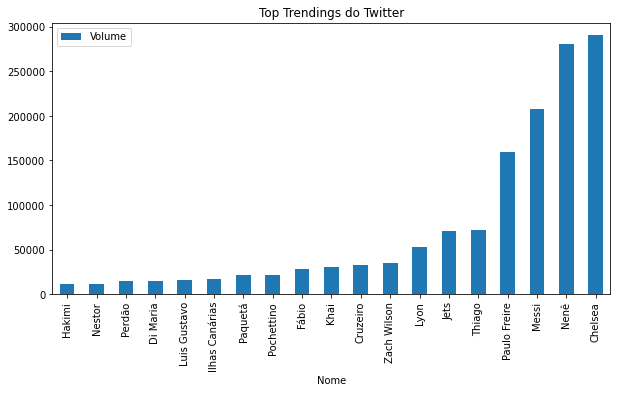

In [27]:
# Volume acima de 0
top = df_trends[df_trends["Volume"] > 0].sort_values("Volume")
top.plot(x="Nome", y=["Volume"], kind="bar", figsize=(10,5))
plt.title('Top Trendings do Twitter')

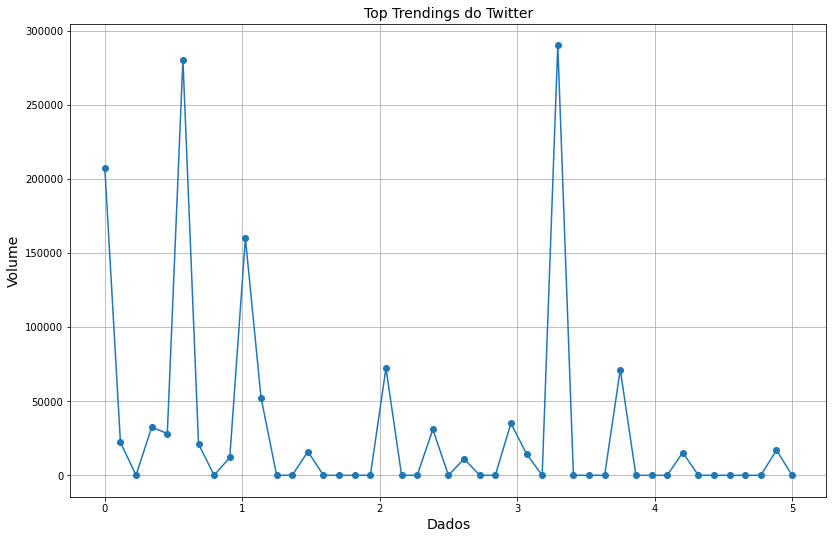

In [29]:
x = np.linspace(0.0, 5.0, 45)
fig, ax = plt.subplots(figsize=(15, 9))
fig.subplots_adjust(bottom=0.15, left=0.2)
plt.plot(x, df_trends["Volume"], marker='o')
plt.title('Top Trendings do Twitter', fontsize=14)
plt.xlabel('Dados', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.grid(True)
plt.show()

<AxesSubplot:xlabel='Nome'>

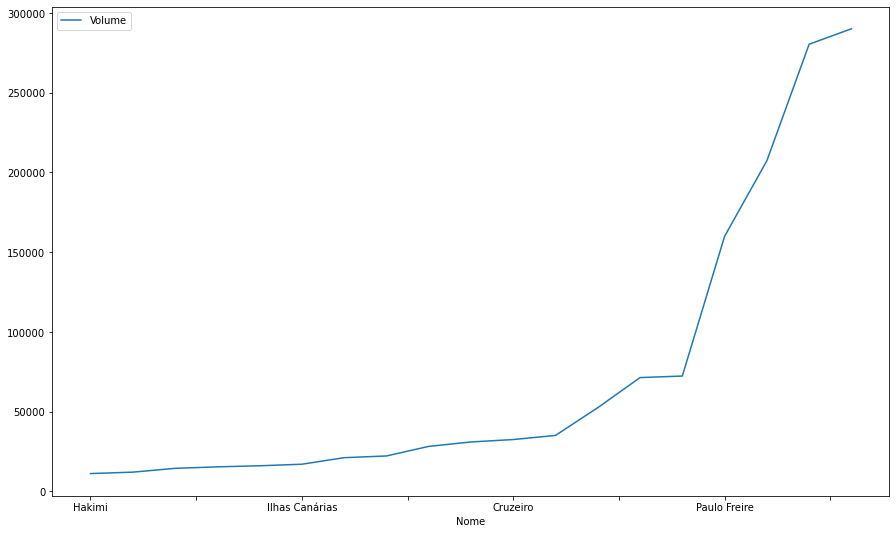

In [30]:
top = df_trends[df_trends["Volume"] > 0].sort_values("Volume")
top.plot(x="Nome", y="Volume", kind='line', figsize=(15,9))

## Funcionalidade 4: Análise de Sentimento
1. Usar o tweepy para obter os tweets.
2. Usar o textblob para analisar os tweets, afim de encontrar sentimentos.
3. Usar a lista de trends obtida na funcionalidade três para servir como paramêtro na função que obtem os tweets.

### Twitter Client

In [31]:
twitter_client = tc.TwitterClient()

### Análise Usando o Dataframe
Para ser realizado a análise de sentimento nos tweets, o laço `for` e a função `iterrows()` do `Dataframe` permite percorrer as linhas do `Dataframe` e através disso, selecionar uma coluna, neste caso a coluna `Nome`, mas pode ser também a coluna `Hashtag` pois no `json` obtido da *request* feita na **Twitter Api** essa coluna se chamava `query`. Pois bem, todos os tweets pegos usando a `query` escolhida são guardadas em uma lista para serem analisadas usando a biblioteca Textblob, se há sentimentos positivos, neutros ou negativos. Descorberto, os sentimentos é feito o calculo para descobrir a porcentagem de tweets que esse sentimento possui.

Além de claro, retornar os tweets ao final.

In [32]:
for index, row in df_trends.iterrows():
    print("O que está sendo comentado no top trendings: " + row['Nome'])
    tweets = twitter_client.get_tweets(query = row['Hashtag'], count = 200)
    
    positive_tweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positivo']
    
    print("Porcentagem de tweets positivos: {} %".format(100*len(positive_tweets)/len(tweets)))
    
    negatives_tweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negativo']
    
    print("Porcentagem de tweets negativos: {} %".format(100*len(negatives_tweets)/len(tweets)))
    
    print("Porcentagem de tweets neutros: {} % \
        ".format(100*(len(tweets) -(len( negatives_tweets )+len( positive_tweets)))/len(tweets)))
    
    print("\n\nTweets positivos:")
    for tweet in positive_tweets[:10]:
        print(tweet['text'])
        
    print("\n\nTweets negativos:")
    for tweet in negatives_tweets[:10]:
        print(tweet['text'])
    print("------------------------------------{}-----------------------------------------------------".format(row["Nome"]))

O que está sendo comentado no top trendings: Messi
Porcentagem de tweets positivos: 12.222222222222221 %
Porcentagem de tweets negativos: 8.88888888888889 %
Porcentagem de tweets neutros: 78.88888888888889 %         


Tweets positivos:
@CrewsMat10 Holy shit everyone was right, Messi really can’t do in any other league let alone Uber eats (6th best in Europe)
RT @AmineMaTue: Ouuuffff la réaction de Messi
@AEdionwele @EdmundOris Messi is struggling in that team make we no lie. He'll come good tho
How does Messi get the blame for the draw? This PSG team should easily be scoring 5 past Lyon with or without Messi.
@MFFooty He wasn’t happy, that didn’t look planned 

I don’t care what the situation is, you don’t take Messi off at 1-1
RT @Letter_to_Jack: yOu wOnT sUbsTitUtE mEsSi wiTh yOuR tEaM... 

*5 days later* 

Dem comot the werey. 

Lmao. https://t.co/oN5bRiX2HS
Ai kijk liever hoe real verliest dan psg zonder messi hor
RT @Djaameel56: Messi qui refuse de serrer la main à Poche mdrrr

D

Porcentagem de tweets positivos: 3.409090909090909 %
Porcentagem de tweets negativos: 3.409090909090909 %
Porcentagem de tweets neutros: 93.18181818181819 %         


Tweets positivos:
RT @Umbarbudotrico1: Como joga Rodrigo Nestor.

Deve ser difícil ser hater do cara, fazendo muito bem a função de armador. https://t.co/SA8…
Nestor é muito bom jogador, mas em jogo grande ainda sente o peso normal de ainda ser um “menino” aos poucos vai se… https://t.co/1hTVGcLS4H
RT @duzin_01: Luan faz seu segundo bom jogo desde a lesão. O primeiro foi a ida contra o Palmeiras. Se mantiver esse nivel - que é o normal…


Tweets negativos:
RT @gabrielfuh_: Falei a base toda e repito no profissional: Nestor é um baita meia de armação. Partida ótima dele hoje mais avançado.
2 - Rodrigo Néstor has had a hand in the same number of goals in the game against Atlético Goianiense (two assists)… https://t.co/nwaLqjfw7q
Falei a base toda e repito no profissional: Nestor é um baita meia de armação. Partida ótima de

Porcentagem de tweets positivos: 4.25531914893617 %
Porcentagem de tweets negativos: 1.0638297872340425 %
Porcentagem de tweets neutros: 94.68085106382979 %         


Tweets positivos:
@thicaires @Cruzeiro mama a minha, primeiro jogo de titular do Marco Antônio, vc merece Henrique e Ariel Cabral, se… https://t.co/2zVy8J8dvB
TIROU O MARCO ANTÔNIO HAHAHAHAHA
Escolheu o pior jogo pra entrar com o Marco Antônio de titular. Com a responsabilidade de marcar o time do Diniz ai… https://t.co/7PBICXLNtg
Marco Antônio titular entrou em campo dormiu e dormiu acordou achou uma assistência pro Thiago e voltou a dormir at… https://t.co/K4qoznYSVi


Tweets negativos:
@LaPosta_Ecu @jeffsanguna Ahora cualquier mediocre es columnista de opinión , periodismo degradado a cero en mi paí… https://t.co/DjNBB7PVwk
------------------------------------Marco Antônio-----------------------------------------------------
O que está sendo comentado no top trendings: Vavá
Porcentagem de tweets positivos: 1.851851851

Porcentagem de tweets positivos: 12.195121951219512 %
Porcentagem de tweets negativos: 0.0 %
Porcentagem de tweets neutros: 87.8048780487805 %         


Tweets positivos:
@JMTL4NTIC perdão por eu ser tão legal
@JMTL4NTIC Perdão por eu ser tão legal
@JMTL4NTIC Perdão por eu ser tão chata

Kkkkk real
perdão por eu ser tão legal https://t.co/8BgqQfwbeN
@mmariiguimaraes Vc tb é gente bixo besta 😂😂

É normal brigar, ter discussões,  pq somos humanos e somos falhos

Só… https://t.co/XJHJ89o67k
perdão por eu ser tão insu     so true https://t.co/SSCSzM9ru1
gmrofivoisfkgdm,re tenho q parar de tweetar esses pensamentos de merda na conta de lol perdao seguidores
perdão por eu ser tão gay https://t.co/R9Jk3lCDGT
perdão por ser tão popular https://t.co/WYH7rPFGRs
perdão por ser tão gay ?????? https://t.co/uX8RdHa4qk


Tweets negativos:
------------------------------------Perdão-----------------------------------------------------
O que está sendo comentado no top trendings: Sai de Baixo
Porcentag

Porcentagem de tweets positivos: 0.0 %
Porcentagem de tweets negativos: 0.0 %
Porcentagem de tweets neutros: 100.0 %         


Tweets positivos:


Tweets negativos:
------------------------------------Paquetop-----------------------------------------------------
O que está sendo comentado no top trendings: Boquetinho
Porcentagem de tweets positivos: 0.0 %
Porcentagem de tweets negativos: 0.0 %
Porcentagem de tweets neutros: 100.0 %         


Tweets positivos:


Tweets negativos:
------------------------------------Boquetinho-----------------------------------------------------
O que está sendo comentado no top trendings: Sandro Meira Ricci
Porcentagem de tweets positivos: 0.0 %
Porcentagem de tweets negativos: 0.0 %
Porcentagem de tweets neutros: 100.0 %         


Tweets positivos:


Tweets negativos:
------------------------------------Sandro Meira Ricci-----------------------------------------------------
O que está sendo comentado no top trendings: Di Maria
Porcentagem de tweets 